In [1]:
using LinearAlgebra
using Printf
using Plots

cd("..")
using Pkg
Pkg.activate(".")
using SBP_operators

In [2]:
function time_solver(soln,RHS,nx,ny,Δx,Δy,x,y,Δt,k,boundary_x,boundary_y;method=:euler,order=2)

    N = ceil(Int64,t_f/Δt)

    for i = 1:N-1
        t = i*Δt
        if method == :euler
            u[:,:,i+1] = u[:,:,i] + Δt*RHS(u[:,:,i+1],u[:,:,i],nx,ny,Δx,x,Δy,y,Δt,t,k,boundary_x,boundary_y,order=order)
        end
    end

    return soln
end

time_solver (generic function with 1 method)

# 2D ADE

$$
\begin{align}
    \frac{\partial u}{\partial t} &= \nabla\cdot(k\nabla u)  \\
    &= k\frac{\partial^2 u}{\partial x^2} + k\frac{\partial^2 u}{\partial y^2}
\end{align}
$$
with boundary condition
$$
\begin{align}
    u(0,y,t) = 0    &\qquad u(L,y,t) = 0    \\
    \frac{\partial}{\partial y}u(x,0,t) = 0    &\qquad \frac{\partial}{\partial y} u(x,L,t) = 0
\end{align}
$$
with initial condition
$$
    u(x,y,0) = \exp(-[(x-L/2)^2 + (y-L/2)^2]/0.02)
$$

In [3]:
function rate(uₓₓ,u,nx,ny,Δx,x,Δy,y,Δt,t,k,gx,gy;order=2)

    uₓₓ = SBP_operators.Dₓₓ(u,nx,ny,Δx,k,dim=1,order=order) + SBP_operators.Dₓₓ(u,nx,ny,Δy,k,dim=2,order=order)

    SAT = zeros(Float64,ny,2*order)

    # x SATs
    for i = 1:ny
        uₓₓ[i,1:order] += SAT_left(:Dirichlet,u[i,1:nx],Δx,gx,order=order,c=k[i,1:nx])
        uₓₓ[i,end-order+1:end] += SAT_right(:Dirichlet,u[i,1:nx],Δx,gx,c=k[i,1:nx],order=order)
    end
    # y SATs
    for i = 1:nx
        uₓₓ[1:order,i] += SAT_left(:Neumann,u[1:ny,i],Δy,gy,c=k[1:ny,i],order=order)
        uₓₓ[end-order+1:end,i] += SAT_right(:Neumann,u[1:ny,i],Δy,gy,c=k[1:ny,i],order=order)
    end

    # println(uₓₓ[end,end])

    return uₓₓ

end

rate (generic function with 1 method)

In [9]:
𝒟 = [0.0 0.0; 1.0 1.0] # [x_0 y_0; x_1 y_1]
nx = ny = 51

Δx = 𝒟[2,1]/(nx-1)
Δy = 𝒟[2,2]/(nx-1)

x = collect(range(𝒟[1,1],𝒟[2,1],step=Δx))
y = collect(range(𝒟[1,2],𝒟[2,2],step=Δy))

k = zeros(Float64,nx,ny) .+ 1.0

# Time domain
Δt = 0.1 * min(Δx^2,Δy^2)
t_f = 50Δt
N = ceil(Int64,t_f/Δt)

# Initial condition
u₀(x,y) = exp.(-((x.-0.5).^2 + (y.-0.5).^2) ./ 0.02)

ϕ_x = [0.0, 1.0]

order = 2
method = :euler

println("Δx=",Δx,"  ","Δy=",Δy,"    ","Δt=",Δt,"    ","final time=",t_f)

Δx=0.02  Δy=0.02    Δt=4.0e-5    final time=0.002


Initialise the simulation

In [10]:
u = zeros(Float64,nx,ny,N)

for i = 1:nx
    for j = 1:ny
        u[i,j,1] = u₀(x[i],y[j])
    end
end

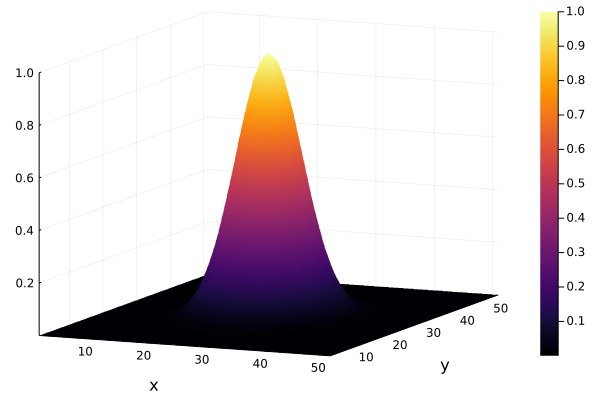

In [11]:
surface(u[:,:,1])
xlabel!("x")
ylabel!("y")

In [12]:
time_solver(u,rate,nx,ny,Δx,Δy,x,y,Δt,k,ϕ_x,[0.0,0.0],method=method,order=order);

┌ Info: Saved animation to 
│   fn = z:\Git-stuff\SBP_operators\yes.gif
└ @ Plots C:\Users\Spiff\.julia\packages\Plots\yiUpW\src\animation.jl:104


Plots.AnimatedGif("z:\\Git-stuff\\SBP_operators\\yes.gif")
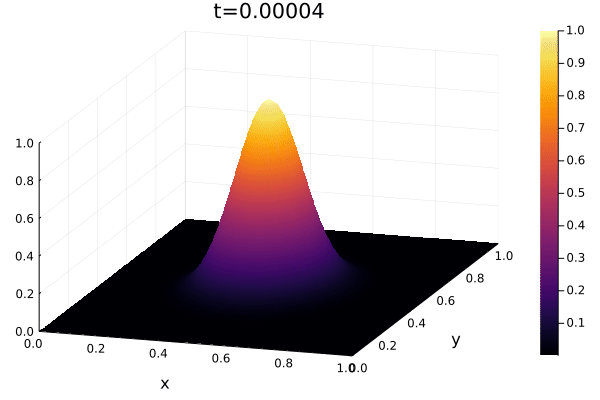

In [40]:
anim = @animate for i = 1:N
    surface(x,y,u[:,:,i],xlabel="x",ylabel="y",title="t=$(@sprintf("%.5f",i*Δt))",
        camera=(20+5*cos(1000*π*i*Δt),50),
        xlim=[0.0,1.0], ylim=[0.0,1.0], zlim=[0.0,1.0])
end

gif(anim,"yes.gif",fps=5)

┌ Info: Saved animation to 
│   fn = z:\Git-stuff\SBP_operators\yes.gif
└ @ Plots C:\Users\Spiff\.julia\packages\Plots\yiUpW\src\animation.jl:104


Plots.AnimatedGif("z:\\Git-stuff\\SBP_operators\\yes.gif")
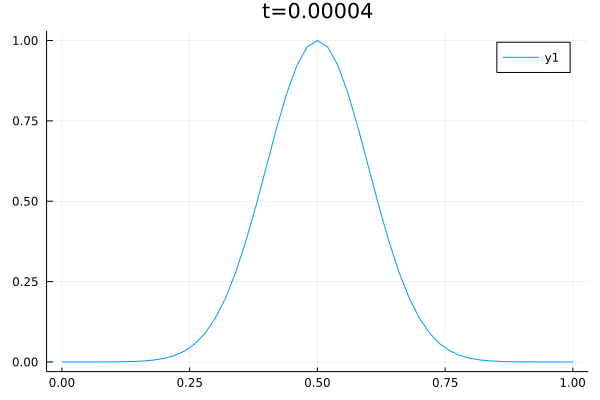

In [9]:
anim = @animate for i = 1:N
    plot(x,u[26,:,i],title="t=$(@sprintf("%.5f",i*Δt))")
end

gif(anim,"yes.gif",fps=3)

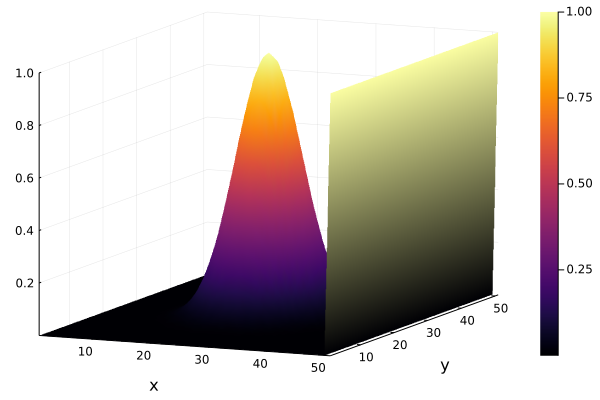

In [29]:
surface(u[:,:,end])
xlabel!("x")
ylabel!("y")